# GPT2 LLM Architecture

The time has come for us to now code the GPT2 LLM architecture using `ttnn`. It involves bringing in a lot of the concepts we have already done in the past and putting them together. 

This notebook has Python code adapted from Build an LLM from Scratch by Sebastian Raschka.

We define what GPT-2 124M looks like. Just declare a dictionary with the necessary parameters.

In [51]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

Okay, so the plan is to create 2 versions of this. A `torch` version, to understand how things work, followed by a `ttnn` version. By the end of the notebook, we'll have a GPT2-based model that can generate some text. (Although mostly nonsense)

# Torch Implementation

We will be bringing back a lot of code we have written in the previous notebooks, but will now tweak and adjust things as necessary. The tweaks we will need to implement will become more obvious when we move to the `ttnn` implementation -- where device memory on the Wormhole now becomes scarce as we now have much more data/components in the model to move around.

Let's import `torch` and `tiktoken` for the Torch implementation of this exercise.

In [52]:
import torch
import tiktoken
from torch import nn

## Basic Workflow: DummyGPTModel
This is more of an optional aside to just demonstrate what a GPT2 model looks like underneath the hood. It is all represented by a model class, and is fundamentally a Python `torch` module! 

We define a quick interface for a `DummyGPTModel` to demonstrate the workflow that we will be programming

In [53]:
class DummyGPTModel(nn.Module):
  def __init__(self, cfg):
    super().__init__()

    self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])
    self.trf_blocks = nn.Sequential(
      *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])]
    )
    self.final_norm = DummyLayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(
      cfg["emb_dim"], cfg["vocab_size"], bias=False
    )

  def forward(self, in_idx):
    batch_size, seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(
      torch.arange(seq_len, device=in_idx.device)
    )

    x = tok_embeds + pos_embeds
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)

    logits = self.out_head(x)
    
    return logits

At the heart of it all, the `DummyTransformerBlock` will be repeated within the model to allow for it to be trained on specific details. More layers, more parameters.

In [54]:
class DummyTransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()

  def forward(self, x):
    return x

class DummyLayerNorm(nn.Module):
  def __init__(self, normalized_shape, eps=1e-5):
    super().__init__()

  def forward(self, x):
    return x

    

Let's create some test data. How about a batch of 2 inputs to complete? We'll tokenize the sentences and put them into a tensor with batch dimensions of 2.

In [55]:
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)

print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


As of right now, when we pass the batch into the model, it's expected that we get logits that pretty much represent random text. That's okay, we are more interested in demonstrating how we will be using our model. 

Eventually, we'll just replace the instantiation of `DummyGPTModel` with `GPTModel`.

In [56]:
torch.manual_seed(123)

model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)


In the world of AI, "logits" are the tensors that are evaluated from passing inputs to a model. They represent the results of the forward pass. I don't remember why we call them "logits". Something to ask an AI?

In [57]:
logits.shape, logits

(torch.Size([2, 4, 50257]),
 tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
          [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
          [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
          [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],
 
         [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
          [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
          [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
          [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
        grad_fn=<UnsafeViewBackward0>))

## Layer Normalization

The whole point of layer normalization is to ensure that the mean and variance of the incoming inputs are in some controlled range.

We want to make sure that our inputs have a mean of `0` and a variance of `1`. 

In order to do that, we need to build a layer that will alter the inputs such that when computing the output of this new modified input, we get a mean of `0` and variance of `1`. 

The following code demonstrates a very simple neural network with just 2 layers -- a linear layer and ReLU layer... it shows how originally, we don't have the expected mean and variance given some input. 

In [58]:
torch.manual_seed(123)

batch_example = torch.randn(2, 5)
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)

out

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)

Expect the mean and variance tensors to not show 0 and 1.

In [60]:
mean = out.mean(dim=-1, keepdim=True)
variance = out.var(dim=-1, keepdim=True)

mean, variance

(tensor([[0.1324],
         [0.2170]], grad_fn=<MeanBackward1>),
 tensor([[0.0231],
         [0.0398]], grad_fn=<VarBackward0>))

But we can alter the data after the fact to get close to the expected mean and variances with a normalization operation.

In [61]:
out_norm = (out - mean) / torch.sqrt(variance)

mean = out_norm.mean(dim=-1, keepdim=True)
variance = out_norm.var(dim=-1, keepdim=True)

out_norm, mean, variance

(tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
         [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
        grad_fn=<DivBackward0>),
 tensor([[    0.0000],
         [    0.0000]], grad_fn=<MeanBackward1>),
 tensor([[1.0000],
         [1.0000]], grad_fn=<VarBackward0>))

In [63]:
torch.set_printoptions(sci_mode=False)

print("Mean", mean)
print("Variance", variance)

Mean tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


So, can we actually take that normalization expression and create a layer that does this for us during our forward pass? Certainly! Let's create a `LayerNorm` torch module to handle that. Finally, now an implementation!

In [64]:
class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()

    self.eps = 1e-5
    
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))

  def forward(self, x):
    mean = x.mean(dim=-1, keepdim=True)
    var = x.var(dim=-1, keepdim=True, unbiased=False)

    norm_x = (x - mean) / torch.sqrt(var + self.eps)

    return self.scale * norm_x + self.shift

Now we can just create a `LayerNorm` instance and pass the input batch. What comes out is a tensor with the expected mean and variance.

This means that we can actually create a neural network with these types of layers to handle the normalization transparently.

In [65]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)

mean = out_ln.mean(dim=-1, keepdim=True)
variance = out_ln.var(dim=-1, unbiased=False, keepdim=True)

print("Mean", mean)
print("Variance", variance)

Mean tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


## GELU Activation


We will use GELU activation. Forgot the reason why in Build a Large Language Model from scratch. I'll update this notebook when I look into it again. But basically you want to ensure that your operations aren't entirely linear. 

In [66]:
class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return 0.5 * x * (1 + torch.tanh(
      torch.sqrt(torch.tensor(2.0 / torch.pi)) *
      (x + 0.044715 * torch.pow(x, 3))
    ))

## Feed Forward

The `FeedForward` portion of the network connects the GELU activation function with other linear layers.

In [67]:
class FeedForward(nn.Module):
  def __init__(self, cfg):
    super().__init__()

    self.layer = nn.Sequential(
      nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
      GELU(),
      nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"])
    )

  def forward(self, x):
    return self.layer(x)

## TransformerBlock

Probably the most important thing here. Our `TransformerBlock` will need our `MultiHeadAttention` module. For the sake of the length of this notebook, I've separated it as a module.

In [68]:
from scripts.multihead_attention import MultiHeadAttention

MultiHeadAttention

scripts.multihead_attention.MultiHeadAttention

In [69]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()

        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"]
        )

        self.ff = FeedForward(cfg)

        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])

        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        
        return x

In [70]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

x.shape, output.shape

(torch.Size([2, 4, 768]), torch.Size([2, 4, 768]))

## Coding the GPT-2 Architecture

Now, we put it together by combining the token embedding and position embedding tensors to become the input embeddings, the transformer block sand the normalization layers to produce logits.

In [71]:
class GPTModel(nn.Module):
  def __init__(self, cfg):
    super().__init__()

    self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])

    self.trf_blocks = nn.Sequential(
      *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
    )

    self.final_norm = LayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(
      cfg["emb_dim"], cfg["vocab_size"], bias=False
    )

  def forward(self, in_idx):
    batch_size, seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)

    pos_embeds = self.pos_emb(
      torch.arange(seq_len, device=in_idx.device)
    )

    x = tok_embeds + pos_embeds
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)

    logits = self.out_head(x)

    return logits

Let's throw in our batch to test...

In [73]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("Input batch shape:\n", batch.shape)

out, out.shape

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
Input batch shape:
 torch.Size([2, 4])


(tensor([[[ 0.1381,  0.0077, -0.1963,  ..., -0.0222, -0.1060,  0.1717],
          [ 0.3865, -0.8408, -0.6564,  ..., -0.5163,  0.2369, -0.3357],
          [ 0.6989, -0.1829, -0.1631,  ...,  0.1472, -0.6504, -0.0056],
          [-0.4290,  0.1669, -0.1258,  ...,  1.1579,  0.5303, -0.5549]],
 
         [[ 0.1094, -0.2894, -0.1467,  ..., -0.0557,  0.2911, -0.2824],
          [ 0.0882, -0.3552, -0.3527,  ...,  1.2930,  0.0053,  0.1898],
          [ 0.6091,  0.4702, -0.4094,  ...,  0.7688,  0.3787, -0.1974],
          [-0.0612, -0.0737,  0.4751,  ...,  1.2463, -0.3834,  0.0609]]],
        grad_fn=<UnsafeViewBackward0>),
 torch.Size([2, 4, 50257]))

Now we can perform the basic inference.

In [74]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


Use the `generate_text_simple` helper to generate some tokens...

In [75]:
from scripts.generate import generate_text_simple

model.eval()
out = generate_text_simple(
  model=model,
  idx=encoded_tensor,
  max_new_tokens=6,
  context_size=GPT_CONFIG_124M["context_length"]
)
print("output:", out)
print("output length:", len(out[0]))

output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
output length: 10


Our decoded text is going to garbage since our model is untrained. But that's okay -- it's good to see something working for the moment.

In [76]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
decoded_text

'Hello, I am Featureiman Byeswickattribute argue'

## Porting to ttnn

I am personally not skilled enough to use the other frameworks right now. so let's be a little creative and just focus on the forward pass of the model and port that to `ttnn`.

For sure this will become complicated later on when we need to do back-propagation. `ttnn` is more of a tensor math library like `numpy` vs. something like `torch`. So I don't think there is inherently things that do all that gradient stuff during training automatically.

We will most likely stick to torch for that, and it will be interesting to see any impact on performance... but let's not worry about that now. (still looking into how to do this with the tenstorrent hardware)

Import everything

In [77]:
import ttnn
import torch
from torch import nn
import tiktoken

torch.manual_seed(123)

Does everything still work with just normal tokenization? Let's take the opportunity to just redefine our input batch anyay.

In [78]:
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)

print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


## Porting over LayerNorm

IMO, this one is the easiest to port over.
One thing you may have noticed over the past several notebooks is that we had dumped our ttnn tensors created in the constructor of these modules to L1 device memory. With the scale of our GPT2 where we will have 124M parameters, we will definitely run out of L1 memory. So going forward, we will no longer be loading data into L1, but will stick to DRAM for simplicity

Additionally, we used to convert our forward pass results in ttnn back to torch. But since these modules will be chained together in the model, we can keep them as ttnn tensors to gain some performance in not having to do the additional device to host memory transfer.

In [26]:
class LayerNorm_ttnn(nn.Module):
  def __init__(self, emb_dim, device):
    super().__init__()

    self.device = device

    self.eps = 1e-5
    
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))

    self.scale_ttnn = ttnn.from_torch(
      self.scale,
      dtype=ttnn.bfloat16,
      layout=ttnn.TILE_LAYOUT,
      device=self.device
    )
    self.shift_ttnn = ttnn.from_torch(
      self.shift,
      dtype=ttnn.bfloat16,
      layout=ttnn.TILE_LAYOUT,
      device=self.device
    )

  def forward(self, x_ttnn):
    mean_ttnn = ttnn.mean(
      x_ttnn,
      dim=-1
    )
    var_ttnn = ttnn.var(
      x_ttnn,
      dim=-1
    )

    norm_x_ttnn = ttnn.div(
      ttnn.subtract(
        x_ttnn,
        mean_ttnn
      ),
      ttnn.sqrt(
        ttnn.add(
          var_ttnn,
          self.eps
        )
      )
    )

    return norm_x_ttnn

We'll compute and then transfer the results back to torch. Notice that our mean and variance actually get pretty close!

In [27]:
if device:
  ttnn.close_device(device)

NameError: name 'device' is not defined

In [28]:
device_id = 0
device = ttnn.open_device(device_id=device_id)

ln = LayerNorm_ttnn(emb_dim=5, device=device)
out_ln = ln(ttnn.from_torch(
  batch_example,
  layout=ttnn.TILE_LAYOUT,
  device=device,
  dtype=ttnn.bfloat16
))

out_ln_torch = ttnn.to_torch(out_ln, device=device)

ttnn.close_device(device)

mean = out_ln_torch.mean(dim=-1, keepdim=True)
variance = out_ln_torch.var(dim=-1, unbiased=False, keepdim=True)


print("Mean", mean)
print("Variance", variance)

                 Device | INFO     | Opening user mode device driver
2025-05-10 15:24:33.251 | INFO     | SiliconDriver   - Opened PCI device 0; KMD version: 1.33.0, IOMMU: disabled

2025-05-10 15:24:33.269 | INFO     | SiliconDriver   - Opened PCI device 0; KMD version: 1.33.0, IOMMU: disabled
2025-05-10 15:24:33.272 | INFO     | SiliconDriver   - Harvesting mask for chip 0 is 0x200 (physical layout: 0x1, logical: 0x200, simulated harvesting mask: 0x0).
2025-05-10 15:24:33.272 | INFO     | SiliconDriver   - Opened PCI device 0; KMD version: 1.33.0, IOMMU: disabled
2025-05-10 15:24:33.273 | INFO     | SiliconDriver   - Detected PCI devices: [0]
2025-05-10 15:24:33.273 | INFO     | SiliconDriver   - Using local chip ids: {0} and remote chip ids {}
2025-05-10 15:24:33.297 | INFO     | SiliconDriver   - Software version 6.0.0, Ethernet FW version 6.14.0 (Device 0)
                  Metal | INFO     | Initializing device 0. Program cache is NOT enabled
                  Metal | INFO     | 

New chip! We now have 1 chips
Chip initialization complete (found )
Chip initializing complete...
 ARC

 [4/4] DRAM

 [16/16] ETH

 CPU

Chip detection complete (found )


                  Metal | WARNING  | Circular buffer indices are not contiguous starting at 0. This will hurt dispatch performance. Non-contiguous indices: 2,3. First unused index: 1. Kernels: writer_unary_interleaved_start_id, reader_unary_reduce_interleaved_start_id, reduce_w
                  Metal | WARNING  | Circular buffer indices are not contiguous starting at 0. This will hurt dispatch performance. Non-contiguous indices: 2. First unused index: 1. Kernels: reader_unary_interleaved_start_id
                  Metal | WARNING  | Circular buffer indices are not contiguous starting at 0. This will hurt dispatch performance. Non-contiguous indices: 2. First unused index: 1. Kernels: writer_unary_interleaved_start_id, reader_unary_interleaved_start_id, eltwise_sfpu
                  Metal | INFO     | Closing device 0
                  Metal | INFO     | Disabling and clearing program cache on device 0
Mean TorchTensor([[-0.0052],
             [-0.0008]], dtype=torch.bfloat16)
Varian

## Porting GELU

In [29]:
class GELU_ttnn(nn.Module):
  def __init__(self, device):
    super().__init__()

    self.device = device

  def forward(self, x_ttnn):
    x_ttnn_cubed = ttnn.pow(
      x_ttnn,
      3
    )

    pi_tensor = ttnn.from_torch(
      torch.tensor(2.0 / torch.pi),
      dtype=ttnn.bfloat16,
      layout=ttnn.TILE_LAYOUT,
      device=self.device
    )

    sqrt_pi_tensor = ttnn.sqrt(
      pi_tensor
    )

    sqrt_factor_ttnn = ttnn.multiply(
      sqrt_pi_tensor,
      ttnn.add(
        x_ttnn,
        ttnn.multiply(
          x_ttnn_cubed,
          0.044715
        )
      )      
    )

    tanh_factor_ttnn = ttnn.tanh(
      sqrt_factor_ttnn
    )

    result_ttnn = ttnn.multiply(
      x_ttnn,
      ttnn.multiply(
        ttnn.add(tanh_factor_ttnn, 1),
        0.5
      )
    )

    return result_ttnn 


In [30]:
ttnn.close_device(device)

                 Always | FATAL    | Attempting to push work to Device 0 which is not initialized. Ignoring...
                 Always | WARNING  | Attempting to synchronize Device 0 which is not initialized. Ignoring...


                  Metal | INFO     | Initializing device 0. Program cache is NOT enabled
                  Metal | INFO     | AI CLK for device 0 is:   1000 MHz


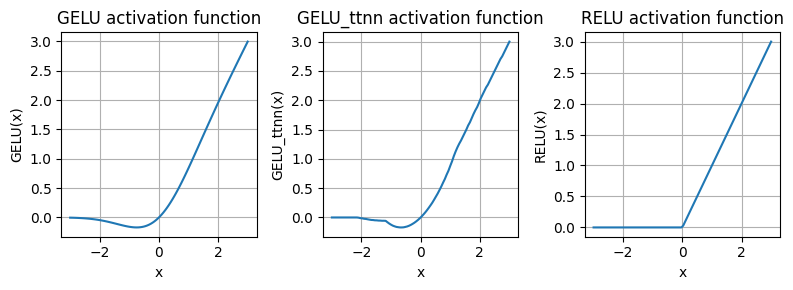

                  Metal | INFO     | Closing device 0
                  Metal | INFO     | Disabling and clearing program cache on device 0


In [31]:
device_id = 0
device = ttnn.open_device(device_id=device_id)

import matplotlib.pyplot as plt

gelu, gelu_ttnn, relu = GELU(), GELU_ttnn(device), nn.ReLU()

# Some sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)
y_gelu_ttnn = ttnn.to_torch(gelu_ttnn(ttnn.from_torch(x, layout=ttnn.TILE_LAYOUT, dtype=ttnn.bfloat16, device=device)), dtype=torch.float32, device=device)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_gelu_ttnn, y_relu], ["GELU", "GELU_ttnn", "RELU"]), 1):
    plt.subplot(1, 3, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

ttnn.close_device(device)

## Porting over Feed Forward


In [32]:
class FeedForward_ttnn(nn.Module):
  def __init__(self, cfg, device):
    super().__init__()

    self.device = device

    self.lin_1 = nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"])
    self.gelu = GELU()
    self.lin_2 = nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"])

    self.lin_1_ttnn = ttnn.from_torch(
      self.lin_1.weight,
      dtype=ttnn.bfloat16,
      layout=ttnn.TILE_LAYOUT,
      device=self.device,
    )
    self.lin_2_ttnn = ttnn.from_torch(
      self.lin_2.weight,
      dtype=ttnn.bfloat16,
      layout=ttnn.TILE_LAYOUT,
      device=self.device,
    )
    self.gelu_ttnn = GELU_ttnn(self.device)


  def forward(self, x_ttnn):
    lin_1_bias = ttnn.from_torch(
      self.lin_1.bias,
      dtype=ttnn.bfloat16,
      layout=ttnn.TILE_LAYOUT,
      device=self.device,
      memory_config=ttnn.L1_MEMORY_CONFIG
    )

    x_ttnn = ttnn.linear(
      x_ttnn,
      self.lin_1_ttnn,
      transpose_b=True,
      bias=lin_1_bias,
    )

    x_ttnn = self.gelu_ttnn(x_ttnn)

    lin_2_bias = ttnn.from_torch(
      self.lin_2.bias,
      dtype=ttnn.bfloat16,
      layout=ttnn.TILE_LAYOUT,
      device=self.device,
      memory_config=ttnn.L1_MEMORY_CONFIG
    )

    x_ttnn = ttnn.linear(
      x_ttnn,
      self.lin_2_ttnn,
      transpose_b=True,
      bias=lin_2_bias,
    )

    return x_ttnn 

Just for comparison, here is the CPU version

In [33]:
torch.manual_seed(123)

ffn = FeedForward(GPT_CONFIG_124M)

# input shape: [batch_size, num_token, emb_size]
x = torch.rand(2, 3, 768) 
out = ffn(x)
out, out.shape

(tensor([[[ 0.0139,  0.0136, -0.1403,  ..., -0.2203, -0.1387, -0.0715],
          [-0.0181,  0.0461, -0.1763,  ..., -0.1154, -0.0052,  0.0039],
          [ 0.0301, -0.0376, -0.1168,  ..., -0.1506, -0.1201, -0.1278]],
 
         [[ 0.0862,  0.0446,  0.0118,  ..., -0.1831, -0.0280, -0.0259],
          [-0.0950,  0.0471, -0.1487,  ..., -0.1297, -0.0834, -0.0053],
          [-0.0161, -0.0762, -0.0622,  ..., -0.0481, -0.0952, -0.1189]]],
        grad_fn=<ViewBackward0>),
 torch.Size([2, 3, 768]))

Now, for our ttnn version

In [34]:
ttnn.close_device(device)

                 Always | WARNING  | Attempting to synchronize Device 0 which is not initialized. Ignoring...


In [35]:
torch.manual_seed(123)

device_id = 0
device = ttnn.open_device(device_id=device_id)

ffn_ttnn = FeedForward_ttnn(GPT_CONFIG_124M, device)
x = torch.rand(2, 3, 768)
out_ttnn = ffn_ttnn(ttnn.from_torch(
  x,
  dtype=ttnn.bfloat16,
  layout=ttnn.TILE_LAYOUT,
  device=device
))

out_ttnn_torch = ttnn.to_torch(out_ttnn, device=device)

ttnn.close_device(device)

out_ttnn_torch, out_ttnn_torch.shape

                  Metal | INFO     | Initializing device 0. Program cache is NOT enabled
                  Metal | INFO     | AI CLK for device 0 is:   1000 MHz
                  Metal | WARNING  | Circular buffer indices are not contiguous starting at 0. This will hurt dispatch performance. Non-contiguous indices: 16. First unused index: 1. Kernels: reader_unary_transpose_wh_interleaved_start_id
                  Metal | WARNING  | Circular buffer indices are not contiguous starting at 0. This will hurt dispatch performance. Non-contiguous indices: 16. First unused index: 1. Kernels: writer_unary_interleaved_start_id, reader_unary_transpose_wh_interleaved_start_id, transpose_wh
                  Metal | WARNING  | Circular buffer indices are not contiguous starting at 0. This will hurt dispatch performance. Non-contiguous indices: 4,5. First unused index: 2. Kernels: reader_bmm_tile_layout_in1_sender_writer_padding, reader_bmm_tile_layout_in0_receiver, bmm_large_block_zm_fused_bias_ac

(TorchTensor([[[ 0.0122,  0.0171, -0.1436,  ..., -0.2275, -0.1348, -0.0737],
               [-0.0181,  0.0486, -0.1807,  ..., -0.1162, -0.0034,  0.0077],
               [ 0.0272, -0.0344, -0.1206,  ..., -0.1533, -0.1221, -0.1240]],
 
              [[ 0.0854,  0.0449,  0.0100,  ..., -0.1836, -0.0322, -0.0273],
               [-0.0942,  0.0488, -0.1533,  ..., -0.1309, -0.0859, -0.0039],
               [-0.0136, -0.0757, -0.0649,  ..., -0.0444, -0.0996, -0.1230]]],
             dtype=torch.bfloat16),
 torch.Size([2, 3, 768]))

Let's use our handy tensor comparison script to see if we've received mostly the same values...

In [36]:
from scripts.compare_tensors import compare_tensors

compare_tensors(out, out_ttnn_torch)

=== Tensor Comparison ===
Shapes: PyTorch torch.Size([2, 3, 768]), TTNN torch.Size([2, 3, 768])
Data types: PyTorch torch.bfloat16, TTNN torch.bfloat16

Tolerance Checks:
  Max Absolute Diff: 0.013672 (Tolerance: 0.020000) ✅ PASS
  Mean Absolute Diff: 0.002380 (Tolerance: 0.020000) ✅ PASS
  Correlation: 1.007812 (Tolerance: 0.990000) ✅ PASS

Overall Status: ✅ PASS

Sample Value Comparisons (first 3 positions):
  Position [0,0,0]: PyTorch=0.013855, TTNN=0.012207, Diff=0.001648 ✅
  Position [0,0,1]: PyTorch=0.013550, TTNN=0.017090, Diff=0.003540 ✅
  Position [0,0,2]: PyTorch=-0.140625, TTNN=-0.143555, Diff=0.002930 ✅
  Position [0,0,3]: PyTorch=0.056396, TTNN=0.062988, Diff=0.006592 ✅
  Position [0,0,4]: PyTorch=0.082520, TTNN=0.083984, Diff=0.001465 ✅
  Position [0,0,5]: PyTorch=0.165039, TTNN=0.169922, Diff=0.004883 ✅
  Position [0,0,6]: PyTorch=0.062500, TTNN=0.060791, Diff=0.001709 ✅
  Position [0,0,7]: PyTorch=0.038330, TTNN=0.042725, Diff=0.004395 ✅
  Position [0,0,8]: PyTorch=-0.2

{'max_diff': 0.013671875,
 'mean_diff': 0.00238037109375,
 'correlation': 1.0078125,
 'max_diff_status': True,
 'mean_diff_status': True,
 'correlation_status': True,
 'overall_status': True}

# Import MultiHeadAttention_ttnn

1. we removed L1 memory 
2. Forward pass returns a ttnn tensor now.
3. Forward pass EXPECTS a ttnn tensor now

In [37]:
from scripts.multihead_attention_ttnn import MultiHeadAttention_ttnn

MultiHeadAttention_ttnn

scripts.multihead_attention_ttnn.MultiHeadAttention_ttnn

## Porting over TransformerBlock

In [38]:
class TransformerBlock_ttnn(nn.Module):
  def __init__(self, cfg, device):
    super().__init__()

    self.cfg = cfg
    self.device = device

    self.att = MultiHeadAttention_ttnn(
      d_in=cfg["emb_dim"],
      d_out=cfg["emb_dim"],
      context_length=cfg["context_length"],
      num_heads=cfg["n_heads"],
      dropout=cfg["drop_rate"],
      qkv_bias=cfg["qkv_bias"],
      device=self.device
    )

    self.ff = FeedForward_ttnn(cfg, self.device)

    self.norm1 = LayerNorm_ttnn(cfg["emb_dim"], self.device)
    self.norm2 = LayerNorm_ttnn(cfg["emb_dim"], self.device)

  def do_dropout(self, x_ttnn):
    x_ttnn = ttnn.experimental.dropout(
      x_ttnn,
      seed=123,
      probability=self.cfg["drop_rate"],
      scale=1.0 / (1.0 - self.cfg["drop_rate"])
    )
    return x_ttnn

  def forward(self, x):
    
    shortcut = x
    x = self.norm1(x)
    x = self.att(x)
    x = self.do_dropout(x) 
    x = ttnn.add(x, shortcut)

    shortcut = x
    x = self.norm2(x)
    x = self.ff(x)
    x = self.do_dropout(x)
    x = ttnn.add(x, shortcut)

    return x

In [39]:
torch.manual_seed(123)

x = torch.rand(2, 4, 768)  # Shape: [batch_size, num_tokens, emb_dim]
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

output

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


tensor([[[ 0.1648,  0.4002, -0.0749,  ...,  1.2646,  0.3324,  0.7243],
         [ 0.0293,  0.0498,  0.2529,  ...,  0.4698,  0.1281,  0.9749],
         [ 0.5532,  0.5788, -0.0310,  ...,  1.1544,  0.3947,  0.7600],
         [ 0.1631,  0.7128,  0.7271,  ...,  0.3312,  0.5730,  0.9258]],

        [[ 0.1787,  1.1682,  0.5810,  ...,  0.1828,  0.0073, -0.5603],
         [-0.2920,  0.6318,  0.2002,  ...,  0.3218,  0.4670, -0.0383],
         [ 0.9275,  0.4203,  0.3183,  ...,  0.3771,  0.7190, -0.1205],
         [ 0.6035,  0.5767,  0.3411,  ...,  1.3798,  1.2683,  0.3916]]],
       grad_fn=<AddBackward0>)

In [40]:
ttnn.close_device(device)

                 Always | WARNING  | Attempting to synchronize Device 0 which is not initialized. Ignoring...


In [41]:
torch.manual_seed(123)

device_id = 0
device = ttnn.open_device(device_id=device_id)

x = torch.rand(2, 4, 768)
block = TransformerBlock_ttnn(GPT_CONFIG_124M, device)
output = block(ttnn.from_torch(x, layout=ttnn.TILE_LAYOUT, dtype=ttnn.bfloat16, device=device))

output_torch = ttnn.to_torch(output, device=device)

ttnn.close_device(device)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

output_torch

                  Metal | INFO     | Initializing device 0. Program cache is NOT enabled
                  Metal | INFO     | AI CLK for device 0 is:   1000 MHz
                  Metal | WARNING  | Circular buffer indices are not contiguous starting at 0. This will hurt dispatch performance. Non-contiguous indices: 16. First unused index: 1. Kernels: reader_unary_interleaved_start_id
                  Metal | WARNING  | Circular buffer indices are not contiguous starting at 0. This will hurt dispatch performance. Non-contiguous indices: 16. First unused index: 1. Kernels: writer_unary_stick_layout_split_rows_multicore, reader_unary_interleaved_start_id, untilize
                  Metal | WARNING  | Circular buffer indices are not contiguous starting at 0. This will hurt dispatch performance. Non-contiguous indices: 16. First unused index: 1. Kernels: reader_unary_pad_dims_split_rows_multicore
                  Metal | WARNING  | Circular buffer indices are not contiguous starting at 0.

TorchTensor([[[ 0.1377,  0.2500, -0.1187,  ...,  1.3047,  0.3691,  0.5938],
              [ 0.0381, -0.0400,  0.0459,  ...,  0.6836,  0.1260,  0.9492],
              [ 0.5430,  0.4297,  0.0234,  ...,  1.1953,  0.4492,  0.6289],
              [ 0.0562,  0.6328,  0.9219,  ...,  0.4668,  0.4023,  0.9414]],

             [[ 0.2002,  1.0781,  0.5117,  ...,  0.2207,  0.1543, -0.4863],
              [-0.1719,  0.5859,  0.2402,  ...,  0.3281,  0.2285,  0.0039],
              [ 0.8555,  0.3320,  0.4238,  ...,  0.2969,  0.8750, -0.1914],
              [ 0.2793,  0.8125,  0.0659,  ...,  1.4766,  1.2109,  0.4336]]],
            dtype=torch.bfloat16)

In [42]:
class GPTModel_ttnn(nn.Module):
  def __init__(self, cfg, device):
    super().__init__()

    self.cfg = cfg
    self.device = device
    self.num_layers = self.cfg["n_layers"]

    self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])    

    self.tok_emb_ttnn = ttnn.from_torch(
      self.tok_emb.weight,
      dtype=ttnn.bfloat16,
      device=self.device,
    )
    self.pos_emb_ttnn = ttnn.from_torch(
      self.pos_emb.weight,
      dtype=ttnn.bfloat16,
      device=self.device,
    )

    # self.trf_blocks = nn.Sequential(
    #   *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
    # )

    self.trf_blocks_ttnn = [
      TransformerBlock_ttnn(self.cfg, self.device) for _ in range(self.num_layers)
    ]



    self.final_norm_ttnn = LayerNorm_ttnn(cfg["emb_dim"], self.device)

    # self.final_norm = LayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(
      cfg["emb_dim"], cfg["vocab_size"], bias=False
    )
    self.out_head_ttnn = ttnn.from_torch(
      self.out_head.weight,
      dtype=ttnn.bfloat16,
      layout=ttnn.TILE_LAYOUT,
      device=self.device,
    )

  def do_dropout(self, x_ttnn):
    x_ttnn = ttnn.experimental.dropout(
      x_ttnn,
      seed=123,
      probability=self.cfg["drop_rate"],
      scale=1.0 / (1.0 - self.cfg["drop_rate"])
    )

    return x_ttnn

  def forward(self, in_idx_ttnn):
    batch_size, seq_len = in_idx_ttnn.shape

    tok_embed_vals_ttnn = ttnn.embedding(
      in_idx_ttnn,
      self.tok_emb_ttnn
    )
    pos_embed_vals_ttnn = ttnn.embedding(
      ttnn.arange(
        start=0,
        end=seq_len,
        step=1,
        dtype=ttnn.uint32,
        device=self.device
      ),
      self.pos_emb_ttnn
    )

    x_ttnn = ttnn.add(
      ttnn.to_layout(tok_embed_vals_ttnn, layout=ttnn.TILE_LAYOUT),
      ttnn.to_layout(pos_embed_vals_ttnn, layout=ttnn.TILE_LAYOUT)
    )

    x_ttnn = self.do_dropout(x_ttnn)

    for trf_block_ttnn in self.trf_blocks_ttnn:
      x_ttnn = trf_block_ttnn(x_ttnn)

    x_ttnn = self.final_norm_ttnn(x_ttnn)

    logits_ttnn = ttnn.linear(
      x_ttnn,
      self.out_head_ttnn,
      transpose_b=True,
    )

    return logits_ttnn

In [43]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("Input batch shape:\n", batch.shape)
print(out)

out, out.shape

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
Input batch shape:
 torch.Size([2, 4])
tensor([[[ 0.1381,  0.0077, -0.1963,  ..., -0.0222, -0.1060,  0.1717],
         [ 0.3865, -0.8408, -0.6564,  ..., -0.5163,  0.2369, -0.3357],
         [ 0.6989, -0.1829, -0.1631,  ...,  0.1472, -0.6504, -0.0056],
         [-0.4290,  0.1669, -0.1258,  ...,  1.1579,  0.5303, -0.5549]],

        [[ 0.1094, -0.2894, -0.1467,  ..., -0.0557,  0.2911, -0.2824],
         [ 0.0882, -0.3552, -0.3527,  ...,  1.2930,  0.0053,  0.1898],
         [ 0.6091,  0.4702, -0.4094,  ...,  0.7688,  0.3787, -0.1974],
         [-0.0612, -0.0737,  0.4751,  ...,  1.2463, -0.3834,  0.0609]]],
       grad_fn=<UnsafeViewBackward0>)


(tensor([[[ 0.1381,  0.0077, -0.1963,  ..., -0.0222, -0.1060,  0.1717],
          [ 0.3865, -0.8408, -0.6564,  ..., -0.5163,  0.2369, -0.3357],
          [ 0.6989, -0.1829, -0.1631,  ...,  0.1472, -0.6504, -0.0056],
          [-0.4290,  0.1669, -0.1258,  ...,  1.1579,  0.5303, -0.5549]],
 
         [[ 0.1094, -0.2894, -0.1467,  ..., -0.0557,  0.2911, -0.2824],
          [ 0.0882, -0.3552, -0.3527,  ...,  1.2930,  0.0053,  0.1898],
          [ 0.6091,  0.4702, -0.4094,  ...,  0.7688,  0.3787, -0.1974],
          [-0.0612, -0.0737,  0.4751,  ...,  1.2463, -0.3834,  0.0609]]],
        grad_fn=<UnsafeViewBackward0>),
 torch.Size([2, 4, 50257]))

In [44]:
if device:
  ttnn.close_device(device)

                 Always | WARNING  | Attempting to synchronize Device 0 which is not initialized. Ignoring...


In [45]:
device_id = 0
device = ttnn.open_device(device_id=device_id)

torch.manual_seed(123)
model = GPTModel_ttnn(GPT_CONFIG_124M, device)

out = model(ttnn.from_torch(batch, dtype=ttnn.bfloat16, layout=ttnn.TILE_LAYOUT, device=device))
print("Input batch:\n", batch)
print("Input batch shape:\n", batch.shape)
print(out)

out_torch = ttnn.to_torch(out, device=device)

ttnn.close_device(device)

out_torch, out_torch.shape

                  Metal | INFO     | Initializing device 0. Program cache is NOT enabled
                  Metal | INFO     | AI CLK for device 0 is:   1000 MHz
Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
Input batch shape:
 torch.Size([2, 4])
ttnn.Tensor([[[-0.76562, -0.43164,  ..., -0.52734, -1.46094],
              [-0.10986, -0.04077,  ..., -0.33984, -0.08252],
              ...,
              [ 0.17773, -0.27539,  ..., -1.05469, -1.07031],
              [-1.30469, -0.27344,  ..., -0.63672, -0.70312]],

             [[ 0.40430, -0.75781,  ...,  0.38672, -1.05469],
              [ 0.77734, -0.47266,  ...,  0.16895,  0.14746],
              ...,
              [ 0.54297, -0.69531,  ...,  0.30078, -0.54688],
              [-0.94531, -0.52734,  ..., -0.83984, -0.34570]]], shape=Shape([2, 4, 50257]), dtype=DataType::BFLOAT16, layout=Layout::TILE)
                  Metal | INFO     | Closing device 0
                  Metal | INFO     | Disabling and

(TorchTensor([[[-0.7656, -0.4316,  0.1875,  ...,  0.5000, -0.5273, -1.4609],
               [-0.1099, -0.0408, -0.1201,  ..., -0.5898, -0.3398, -0.0825],
               [ 0.1777, -0.2754,  0.0227,  ...,  0.6016, -1.0547, -1.0703],
               [-1.3047, -0.2734,  0.1748,  ...,  0.6523, -0.6367, -0.7031]],
 
              [[ 0.4043, -0.7578, -0.4766,  ..., -0.3262,  0.3867, -1.0547],
               [ 0.7773, -0.4727,  0.0879,  ..., -0.1387,  0.1689,  0.1475],
               [ 0.5430, -0.6953,  0.7539,  ...,  0.8555,  0.3008, -0.5469],
               [-0.9453, -0.5273, -0.5234,  ...,  0.9414, -0.8398, -0.3457]]],
             dtype=torch.bfloat16),
 torch.Size([2, 4, 50257]))

In [46]:


start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)
print(encoded_tensor)



encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])
tensor([[15496,    11,   314,   716]])


In [47]:
if device:
  ttnn.close_device(device)

                 Always | WARNING  | Attempting to synchronize Device 0 which is not initialized. Ignoring...


In [48]:

from scripts.generate_ttnn import generate_text_simple_ttnn

device_id = 0
device = ttnn.open_device(device_id=device_id)

torch.manual_seed(123)
model = GPTModel_ttnn(GPT_CONFIG_124M, device)

input_ttnn = ttnn.from_torch(encoded_tensor, dtype=ttnn.uint32, layout=ttnn.TILE_LAYOUT, device=device)
print(input_ttnn)
out = generate_text_simple_ttnn(
  model=model,
  idx_ttnn=input_ttnn,
  max_new_tokens=6,
  context_size=GPT_CONFIG_124M["context_length"],
  device=device
)
print("output:", out)
print("output length:", len(out[0]))

ttnn.close_device(device)

out, out.shape

                  Metal | INFO     | Initializing device 0. Program cache is NOT enabled
                  Metal | INFO     | AI CLK for device 0 is:   1000 MHz
ttnn.Tensor([[15496,    11,  ...,   314,   716]], shape=Shape([1, 4]), dtype=DataType::UINT32, layout=Layout::TILE)
TorchTensor([[15496,    11,   314,   716]], dtype=torch.int32)
output: TorchTensor([[15496,    11,   314,   716, 27018, 29289, 16815, 22210, 21945,
              46968]])
output length: 10
                  Metal | INFO     | Closing device 0
                  Metal | INFO     | Disabling and clearing program cache on device 0


(TorchTensor([[15496,    11,   314,   716, 27018, 29289, 16815, 22210, 21945,
               46968]]),
 torch.Size([1, 10]))

In [49]:

decoded_text = tokenizer.decode(out.squeeze(0).tolist())
decoded_text

'Hello, I am Featurelayer prevalenceSomethingroleum convol'

Tada! We have a model to now train! 😀